# Homework #3 -- *you'll need to do this on google colab*

0. Find data set on [kaggle](https://www.kaggle.com).
1. Provide posterior inference for a column of data with a `PyMC` ***normal-gamma specification***. 
2. Find a different column of data for which a ***normal-gamma specification*** isn't justified. 
3. Create a different `PyMC` specification that IS appropriate for this new data column:
    - here are your `PyMC` choices for [continuous distributions](https://www.pymc.io/projects/docs/en/stable/api/distributions/continuous.html)
    - here are your `PyMC` choices for [discrete distributions](https://www.pymc.io/projects/docs/en/stable/api/distributions/discrete.html)

### ...just make sure you've chosen a reasonable likelihood for your non-normal data and that the support of your priors makes sense for the values the parameters of your likelihood can take on... 

4. Provide posterior inference for the parameters of your new specification given the column of non-normal data
using `PyMC` and provide an analysis of the MCMC chains. 

In [35]:
import pymc as pm
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import arviz as az

# Question 0

In [68]:
df = pd.read_csv("kaggledata.csv")

## Question 1

(array([ 20., 249., 327., 227., 174., 109.,  64.,  32.,   8.,   7.]),
 array([1.81 , 2.022, 2.234, 2.446, 2.658, 2.87 , 3.082, 3.294, 3.506,
        3.718, 3.93 ]),
 <BarContainer object of 10 artists>)

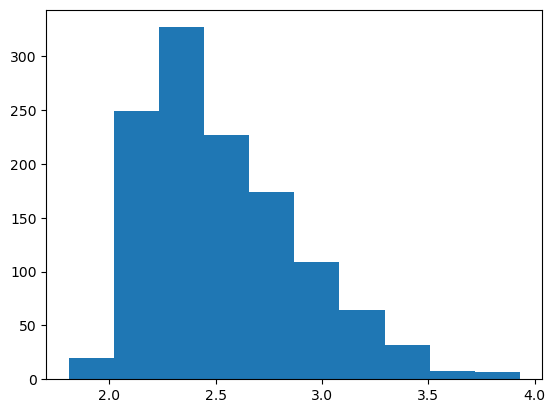

In [69]:
norm_data = df["Average ELA Proficiency"].dropna()
plt.hist(norm_data)

In [70]:
theta_0,tau = 0,1; alpha,beta = 2,1/2 # Initialize Prior Hyperparameters: specify prior distributions
normal_gamma_toy_model = pm.Model()
with normal_gamma_toy_model: 
    theta = pm.Normal("theta", mu=0, sigma=1)
    phi = pm.Gamma("phi", alpha=1, beta=1)
    x_obs = pm.Normal("likelihood", mu=theta, sigma=1/phi**0.5, observed=norm_data)

In [71]:
with normal_gamma_toy_model:
    idata_HMC = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, phi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [72]:
with normal_gamma_toy_model:
    MH = pm.Metropolis([theta, phi], S=np.array([0.1]), tune=False, tune_interval=0)
    idata_MH = pm.sample(step=MH) # force MH

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [theta]
>Metropolis: [phi]


Sampling 4 chains for 0 tune and 2_000 draw iterations (0 + 8_000 draws total) took 1 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


HMC Split-Rhats {'theta': 1.0003, 'phi': 1.0003} | MH Split-Rhats {'theta': 1.0112, 'phi': 1.0097}


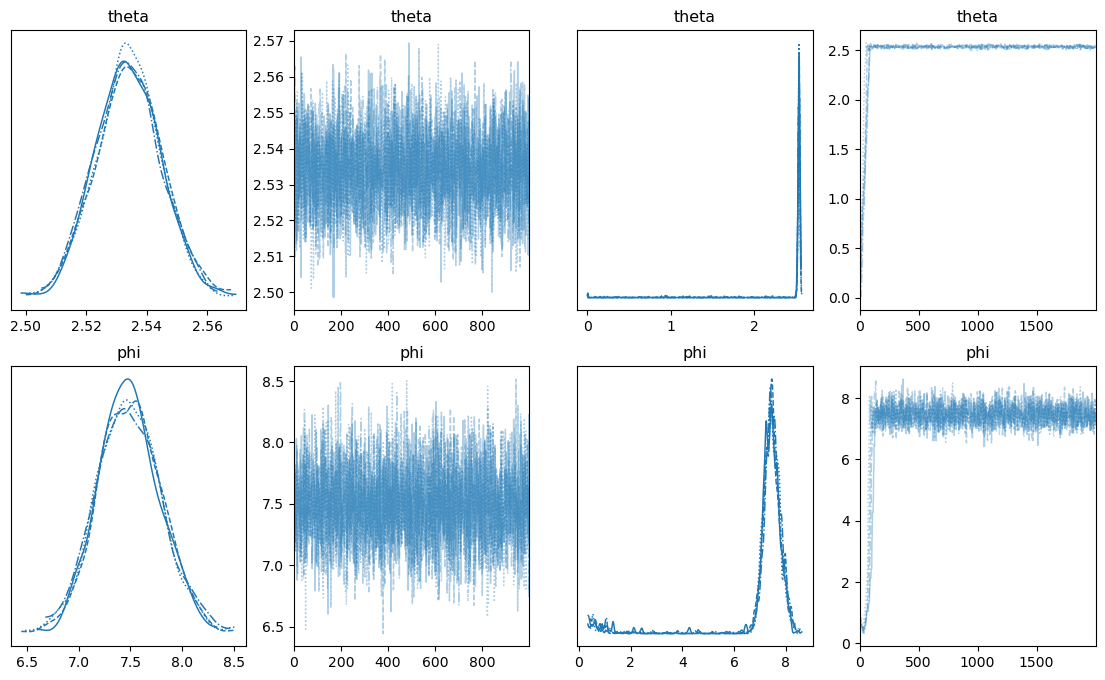

In [73]:
fig,ax = plt.subplots(2,4, figsize=(14,8))
az.plot_trace(idata_HMC, axes=ax[:2,:2]); 
az.plot_trace(idata_MH, axes=ax[:2,2:])
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC).items()}, end=' | '); 
print('MH Split-Rhats',{k: np.round(v.values,4) for k,v in az.rhat(idata_MH).items()})

/opt/conda/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/opt/conda/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/opt/conda/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/opt/conda/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning:

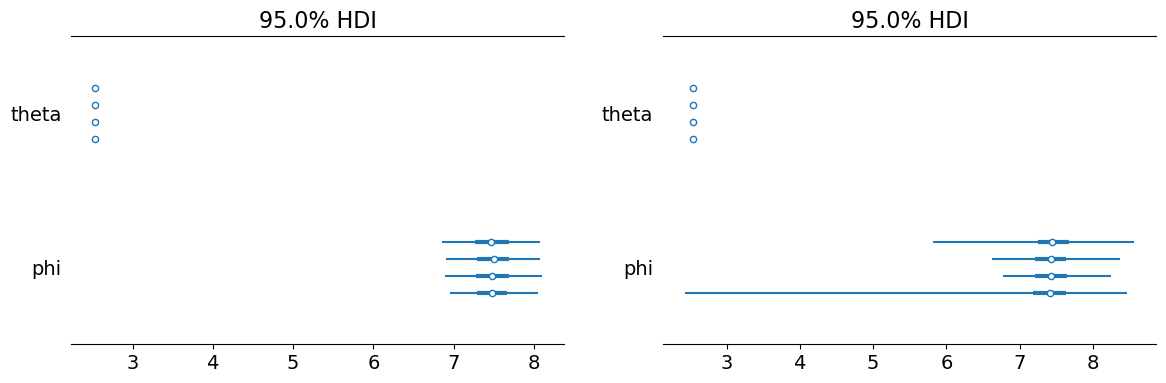

In [74]:
fig,ax = plt.subplots(1,2, figsize=(14,4))
az.plot_forest(idata_HMC, var_names=["theta","phi"], combined=False, hdi_prob=0.95, ax=ax[0]);
az.plot_forest(idata_MH, var_names=["theta","phi"], combined=False, hdi_prob=0.95, ax=ax[1]);

# Question 2

(array([ 24.,  33.,  62.,  60.,  70., 123., 146., 212., 300., 217.]),
 array([0.049 , 0.1398, 0.2306, 0.3214, 0.4122, 0.503 , 0.5938, 0.6846,
        0.7754, 0.8662, 0.957 ]),
 <BarContainer object of 10 artists>)

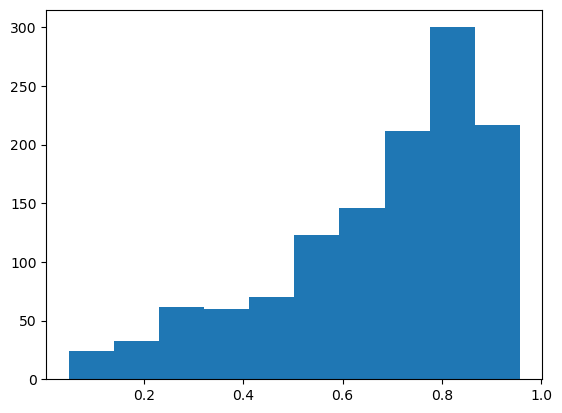

In [75]:
data2 = df["Economic Need Index"].dropna()
plt.hist(data2)

It seems that this data follows a beta distribution.

# Question 3

As I considerred this distribution to be a beta distribution and the parameters and greater than 0, so I choose a chisquared distribution for both parameter.

In [79]:
alpha,beta = 2,1/2 # Initialize Prior Hyperparameters: specify prior distributions
nonnormal_toy_model = pm.Model()
with nonnormal_toy_model: 
    alpha = pm.ChiSquared("alpha", nu = 1)
    beta = pm.ChiSquared("beta", nu = 1)
    x_obs = pm.Beta("likelihood", alpha=alpha, beta=beta, observed=data2)

In [85]:
with nonnormal_toy_model:
    ndata_HMC = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [86]:
with nonnormal_toy_model:
    MH = pm.Metropolis([alpha, beta], S=np.array([0.1]), tune=False, tune_interval=0)
    ndata_MH = pm.sample(step=MH) # force MH

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]


Sampling 4 chains for 0 tune and 2_000 draw iterations (0 + 8_000 draws total) took 1 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


# Question 4

HMC Split-Rhats {'alpha': 1.0009, 'beta': 1.0018} | MH Split-Rhats {'alpha': 1.008, 'beta': 1.0061}


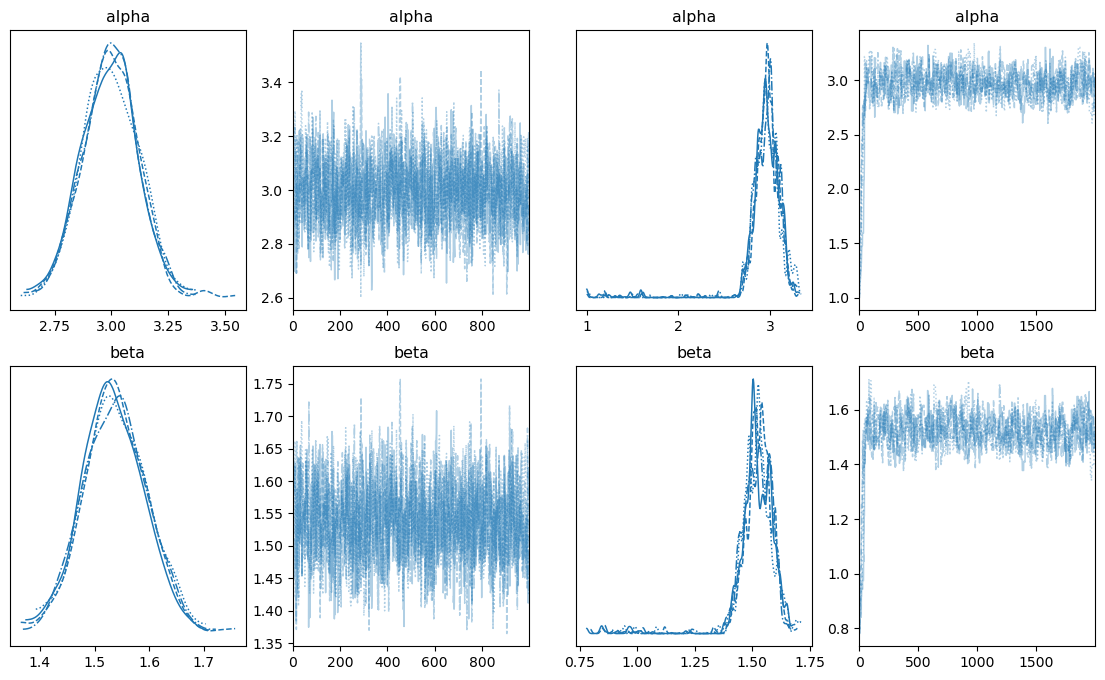

In [87]:
fig,ax = plt.subplots(2,4, figsize=(14,8))
az.plot_trace(ndata_HMC, axes=ax[:2,:2]); 
az.plot_trace(ndata_MH, axes=ax[:2,2:])
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(ndata_HMC).items()}, end=' | '); 
print('MH Split-Rhats',{k: np.round(v.values,4) for k,v in az.rhat(ndata_MH).items()})

We observe that for the Hamiltonian Monte Carlo (HMC) graphs, the distribution for both parameters is normal. Additionally, both graphs are confined to a small interval.

In contrast, for the Metropolis-Hastings (MH) graphs, we notice that both parameters start from an incorrect value and then shift to the correct interval due to our sample. Since MH makes the estimates dependent on previous estimates, unlike the HMC graphs, we can see that both parameters in MH graphs shift gradually.

/opt/conda/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/opt/conda/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/opt/conda/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/opt/conda/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning:

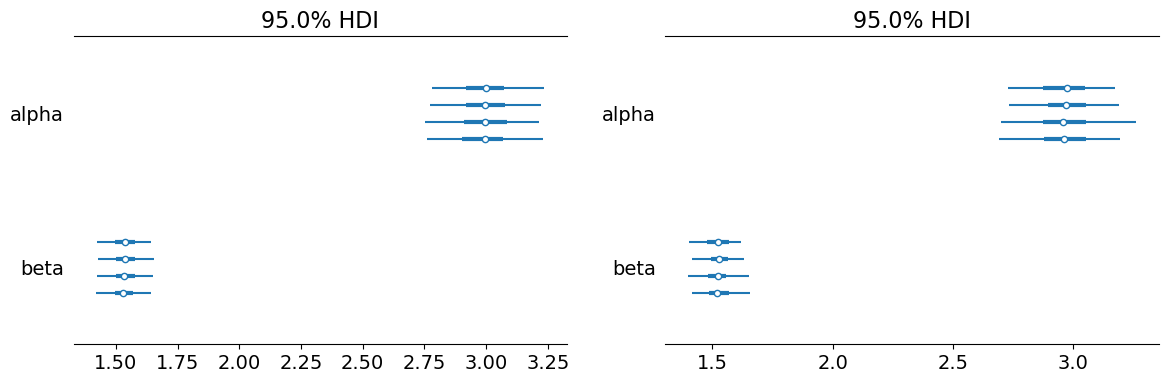

In [89]:
fig,ax = plt.subplots(1,2, figsize=(14,4))
az.plot_forest(ndata_HMC, var_names=["alpha","beta"], combined=False, hdi_prob=0.95, ax=ax[0]);
az.plot_forest(ndata_MH, var_names=["alpha","beta"], combined=False, hdi_prob=0.95, ax=ax[1]);

We observe that for both strategies, alpha is approximately 3, and beta is approximately 1.5. In other words, alpha is greater than beta, consistent with our left-skewed graph. Additionally, the sample error for both parameters is minimal, as evidenced by the narrow intervals.